# Imports

In [22]:
import os 
path = os.getcwd()
%matplotlib inline
if path[1:5] == "Home":
    %run /Home/siv30/wad005/master/GRB/src/paths/uib.ipynb
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    %run /Home/siv30/wad005/master/GRB/src/convert_erg.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
else:
    %run /Users/andreas/phys/master/GRB/src/paths/mac.ipynb # Mac paths
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    %run /Users/andreas/phys/master/GRB/src/convert_erg.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb


All MAC paths are set!


/Users/andreas/fun/useful_py_func/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None


<Figure size 800x500 with 0 Axes>

/Users/andreas/fun/useful_py_func/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None
/Users/andreas/fun/useful_py_func/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None
/Users/andreas/fun/useful_py_func/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None



All MAC paths are set!

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!

All MAC paths are set!

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!


/Users/andreas/fun/useful_py_func/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None
/Users/andreas/fun/useful_py_func/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None
/Users/andreas/fun/useful_py_func/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None
/Users/andreas/fun/useful_py_func/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for

convert_erg.ipynb loaded successfully!

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!


/Users/andreas/fun/useful_py_func/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None
/Users/andreas/fun/useful_py_func/matplotlib_custom_style_and_macros.py:128: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  rcParams['lines.marker'] = None


convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


# Notes
    New script harvests 30 less counts ~ 0.2 %
    Don't bother with this...
    Think st criteria have already been implemented

# Background extraction

In [2]:
T0 = datetime.fromisoformat('2019-03-05T13:05:19.816')
df = harvest_data(fn='2019_3_5_13_3_48',T0='2019-03-05T13:05:19.816')
tus = df['tus'].to_numpy()
len(tus),type(tus)

(21914, numpy.ndarray)

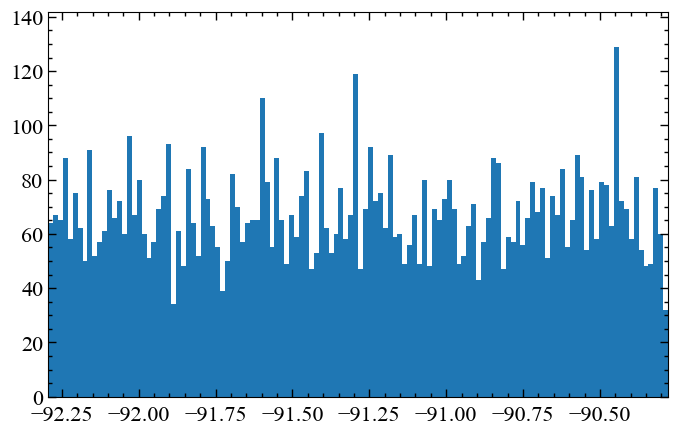

In [3]:
dt = 0.016
i=find_nearest(tus,-2)
bins_bg = np.arange(min(tus[:i]),max(tus[:i])+dt,dt)
plt.hist(tus[:i],bins=bins_bg)
plt.show()

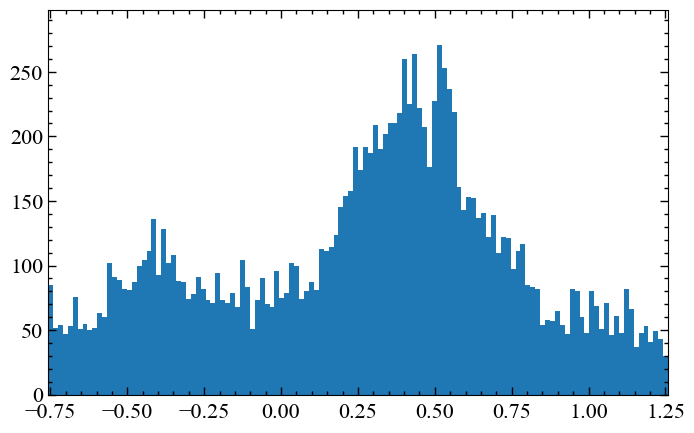

In [4]:
dt = 0.016
i=find_nearest(tus,-2)
bins_burst = np.arange(min(tus[i:]),max(tus[i:])+dt,dt)
plt.hist(tus[i:],bins=bins_burst)
plt.show()

In [7]:
print(len(tus[i:])-30,13444)
print('removed 30 counts due to ST')
print('Arrays match excactly!')

13444 13444
removed 30 counts due to ST
Arrays match excactly!


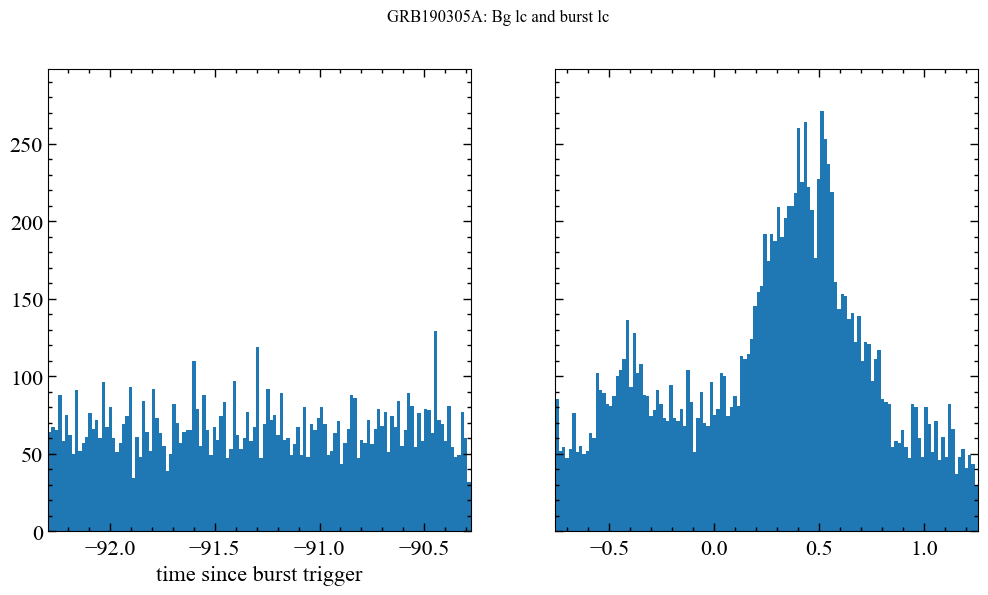

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True,figsize=(12, 6))
fig.suptitle('GRB190305A: Bg lc and burst lc')
ax1.hist(tus[:i],bins=bins_bg)
ax2.hist(tus[i:],bins=bins_burst)
ax1.set_xlabel("time since burst trigger")
plt.show()

In [9]:
print("burst T0: ", T0)
print("bg T0:",T0-timedelta(seconds=90))
print("iss lon,lat position (at T0): ",84.887, -51.772)
print("iss lon,lat position (at bg): ", 75.929,-51.595)
print("location: indian ocean")
print("travelled ~620 km from bg to burst (~90 sec)")

burst T0:  2019-03-05 13:05:19.816000
bg T0: 2019-03-05 13:03:49.816000
iss lon,lat position (at T0):  84.887 -51.772
iss lon,lat position (at bg):  75.929 -51.595
location: indian ocean
travelled ~620 km from bg to burst (~90 sec)


# DATAFRAME HANDLING
    TODO: To make a fits file out of the data harvested, one needs to implement the safetytime criteria.
    To implement that, I have to create a column for the adr for the trigger.
    
    tlagg= 0.472s
    
    tus (time trigger) should be kept in MICRO SECONDS!
    

In [26]:
df = harvest_data(fn='2019_3_5_13_3_48',T0='2019-03-05T13:05:19.816')
df = make_adr(df)
keV,cal_abc = convert_erg(df['energy_ch'].to_numpy(),df['dau'].to_numpy(),df['det'].to_numpy(),T0)
df['keV'] = keV
df['tus'] = df['tus'].to_numpy(np.float64)*1e6 #converting to microseconds
print('tus array now in microseconds')

df.sort_index(inplace=True)
i_burst_start = find_nearest(df['tus'].to_numpy()/1e6,-1)
df_bg = df.truncate(after=i_burst_start-1)
df_burst = df.truncate(before=i_burst_start)

df_bg.sort_values(by=['adr','tus'],inplace=True)
df_burst.sort_values(by=['adr','tus'],inplace=True)

#DataFrames ready for analysis

dau/det starting from index 1
tus array given in seconds
tus array now in microseconds


In [28]:
df_bg.head()

,year,month,day,hour,minute,second,energy_ch,dau,det,datetime,tus,adr,keV
13,2019,3,5,13,3,47.525428,28,1,1,2019-03-05 13:03:47.525427861,-9.229057e+07,1,282.502204
15,2019,3,5,13,3,47.525878,43,1,1,2019-03-05 13:03:47.525877778,-9.229012e+07,1,406.136344
30,2019,3,5,13,3,47.530015,52,1,1,2019-03-05 13:03:47.530014972,-9.228599e+07,1,481.408924
38,2019,3,5,13,3,47.53014,408,1,1,2019-03-05 13:03:47.530140111,-9.228586e+07,1,4115.834284
65,2019,3,5,13,3,47.537834,1768,1,1,2019-03-05 13:03:47.537834472,-9.227817e+07,1,29799.646444


In [25]:
df_burst.head()

,year,month,day,hour,minute,second,energy_ch,dau,det,datetime,tus,adr,keV
8440,2019,3,5,13,5,19.058593,1768,1,1,2019-03-05 13:05:19.058593278,-757406.722,1,29799.646444
8453,2019,3,5,13,5,19.060647,66,1,1,2019-03-05 13:05:19.060646778,-755353.222,1,600.127636
8463,2019,3,5,13,5,19.061622,1925,1,1,2019-03-05 13:05:19.061621972,-754378.028,1,33968.798400
8472,2019,3,5,13,5,19.062818,26,1,1,2019-03-05 13:05:19.062817583,-753182.417,1,266.189556
8483,2019,3,5,13,5,19.067037,72,1,1,2019-03-05 13:05:19.067037111,-748962.889,1,651.613804


# SAFETY TIME

In [29]:
def get_flag(st_arr,dt_arr):
    flag = []
    i = 0
    while i < len(st_arr):
        if i == 0:
            flag.append(False)
            i += 1

        elif dt_arr[i] >= st_arr[i-1]:
            flag.append(False)
            i+=1

        elif dt_arr[i] <= st_arr[i-1]:
            st,diff = st_arr[i-1], dt_arr[i]
            flags = 0
            i += 1
            #have to take into account that there can be triggers incoming while the st have not been reset
            while diff < st: #problem here
                if i == len(st_arr):
                    flags+=1
                    flag.extend(flags*[True])
                    return flag
                else:
                    diff += dt_arr[i]
                    flags += 1
                    i +=1
            flag.extend(flags*[True])
            i -= 1
        else:
            flag.append(False)
            i += 1
    return np.array(flag)

## flags for bg

In [30]:
st_bg,dt_bg = get_st(df_bg),get_dt(df_bg)
df_bg['st'],df_bg['dt'] = np.array(st_bg),np.array(dt_bg)

st_bg,dt_bg = df_bg["st"].to_numpy(),df_bg["dt"].to_numpy()
flag_bg = get_flag(st_bg,dt_bg)
df_bg['flag'] = flag_bg

flag_label = []
for flag_idx,row in df_bg.iterrows():
    if row["flag"]==True:
        flag_label.append(flag_idx)

print("Removed " + str(len(flag_label)) + " flags from df")
df_bg.drop(labels=flag_label,inplace=True)

Removed 23 flags from df


## flags for burst

In [31]:
st,dt = get_st(df_burst),get_dt(df_burst)
df_burst['st'],df_burst['dt'] = np.array(st),np.array(dt)

st_burst,dt_burst = df_burst["st"].to_numpy(),df_burst["dt"].to_numpy()
flag_burst = get_flag(st_burst,dt_burst)
df_burst['flag'] = flag_burst

flag_label = []
for flag_idx,row in df_burst.iterrows():
    if row["flag"]==True:
        flag_label.append(flag_idx)

print("Removed " + str(len(flag_label)) + " flags from df")
df_burst.drop(labels=flag_label,inplace=True)

Removed 30 flags from df


## plotting LC's

In [49]:
tus_bg = df_bg['tus'].to_numpy(dtype=np.float64)
tus_burst = df_burst['tus'].to_numpy(dtype=np.float64)

tus array OK ...


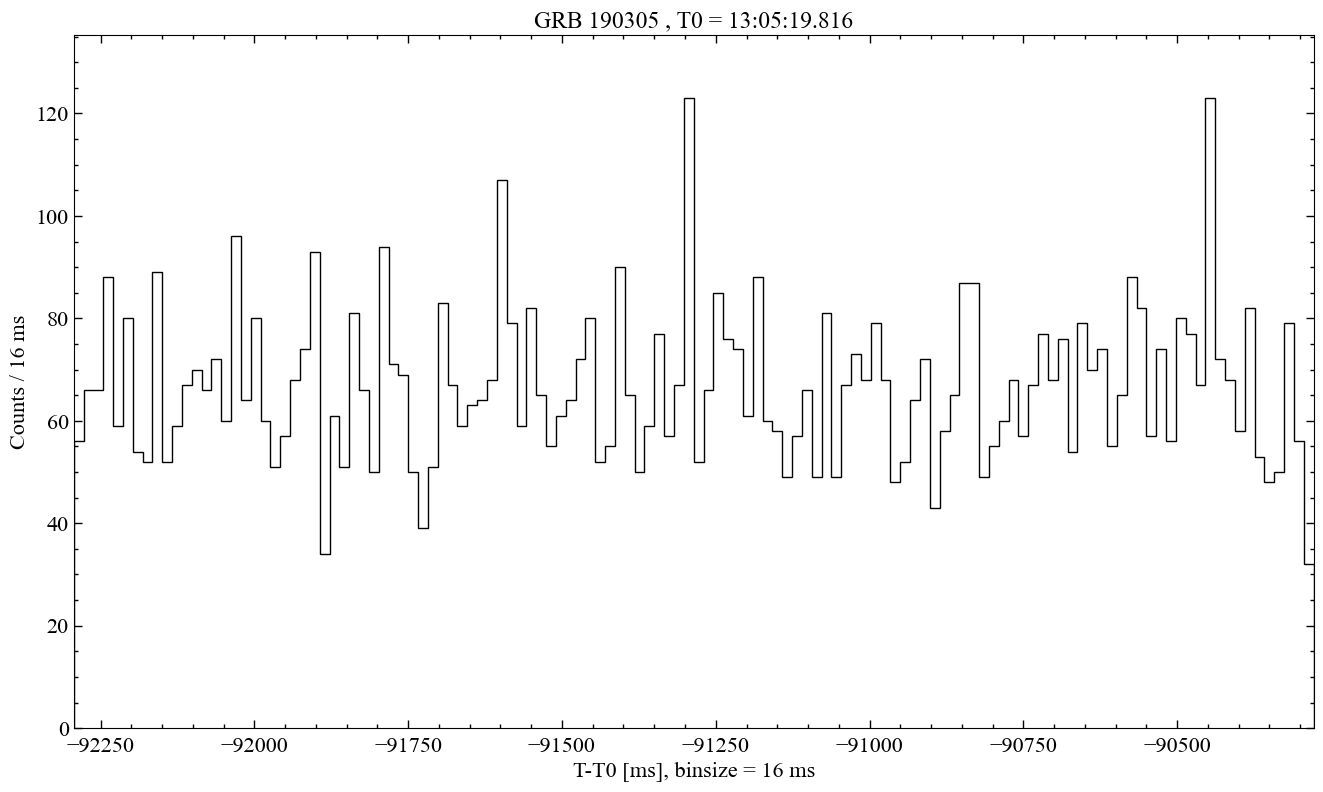

In [50]:
plot_HED(tus_arr=tus_bg,T0=T0,binsize=16)

tus array OK ...


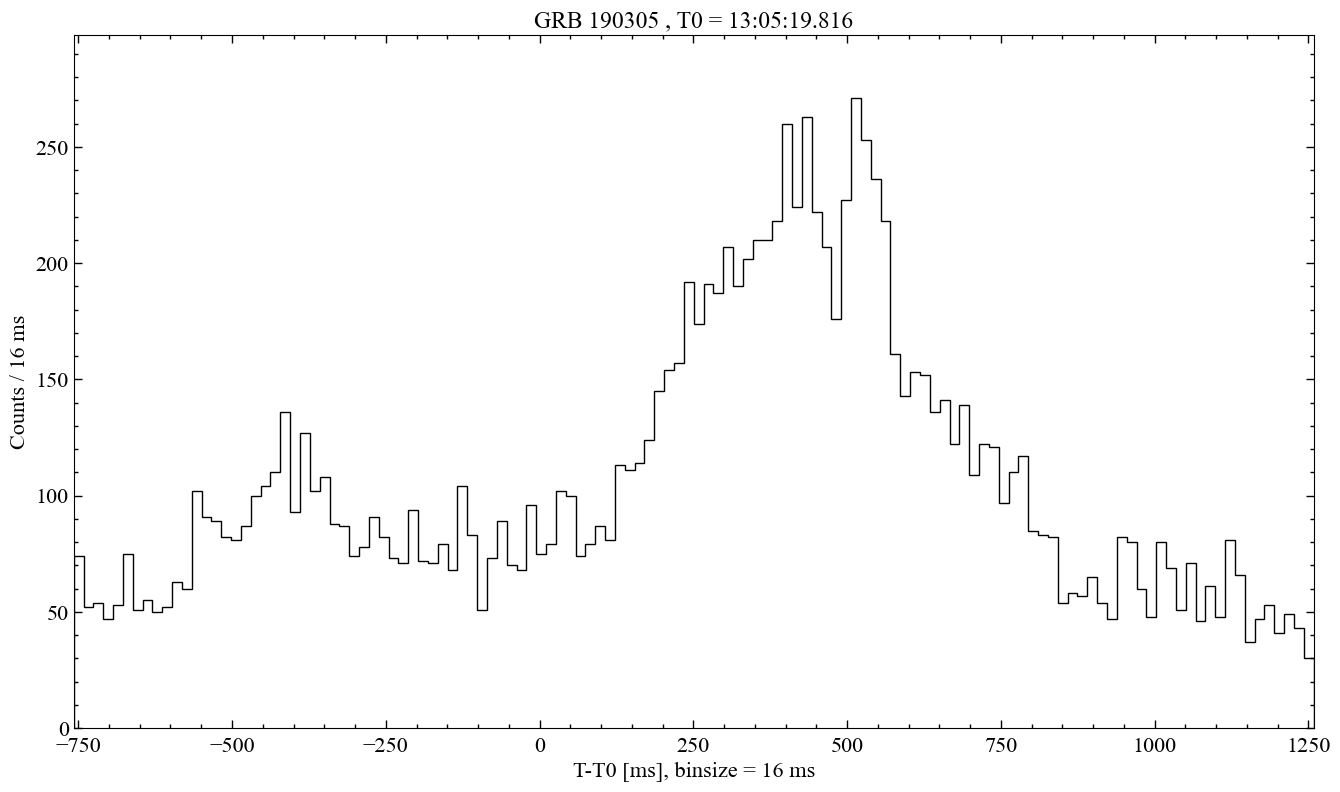

In [51]:
plot_HED(tus_arr=tus_burst,T0=T0,binsize=16)

# Cross Corrolation of burst LC

In [52]:
#calculating the tlagg approx based on trigger times and ToF
#bringing into KW ref frame...
#T0_ASIM = 13:05:19.816 abs time correction accounted for
#T0_KW = 13:05:15:900
#ToF = 3.4460
tlagg_approx = np.round(19.816-15.900-3.4460,3)
print(tlagg_approx)

0.47


### KW

-0.25
1.504


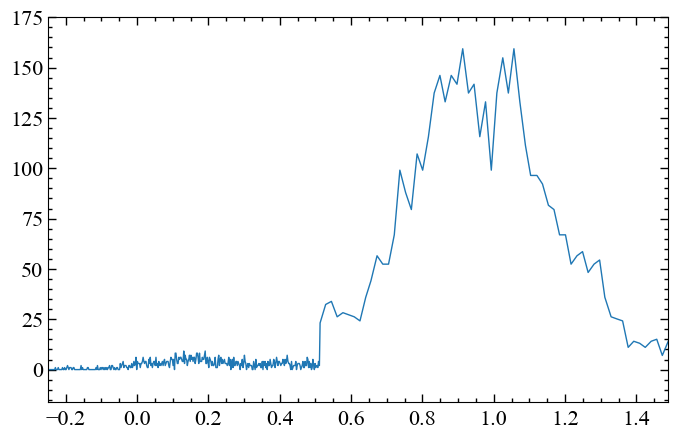

In [53]:
kw_filename = "GRB190305A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

#kw_dt = np.round(np.diff(kw_bin_lo),3)
#i_stop_kw = np.where(kw_dt>2*binsize)[0][0]

#cutting LC at T0+1.5 s, so that both LC's have 2s of data
i_start_kw = find_nearest(kw_bin_lo,-0.25)
print(kw_bin_lo[i_start_kw])
i_stop_kw = find_nearest(kw_bin_lo,1.5)
print(kw_bin_lo[i_stop_kw])


kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[i_start_kw:i_stop_kw], kw_bin_hi[i_start_kw:i_stop_kw], G1[i_start_kw:i_stop_kw],G2[i_start_kw:i_stop_kw], G3[i_start_kw:i_stop_kw]
kwCounts = G3
kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

### HED

In [60]:
df_burst['tus'].to_numpy()

array([-757406.722, -755353.222, -754378.028, ..., 1248033.667,
       1249335.332, 1249338.167])

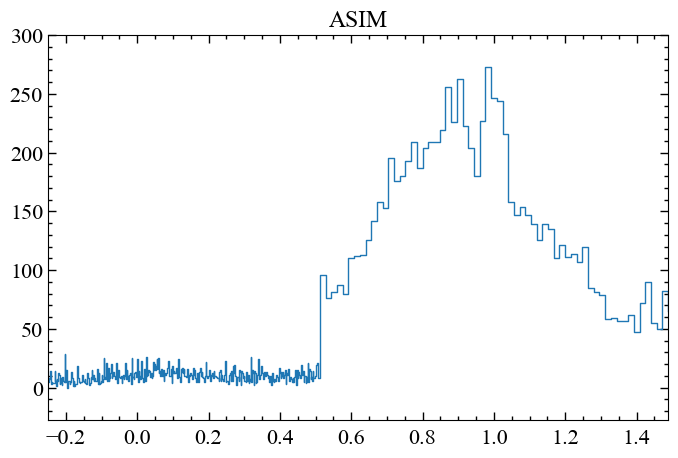

In [61]:
tus_burst = df_burst['tus'].to_numpy()/1e6 #converting back to seconds for CC
tus_burst += tlagg_approx
hist = np.histogram(tus_burst,bins=np.append(kw_bin_lo,kw_bin_hi[-1])) #using KW bins
asimCounts,asimEdges = hist[0],hist[1]

plt.step(x=asimEdges[:-1],y=asimCounts,where="post")
plt.title("ASIM")
plt.show()

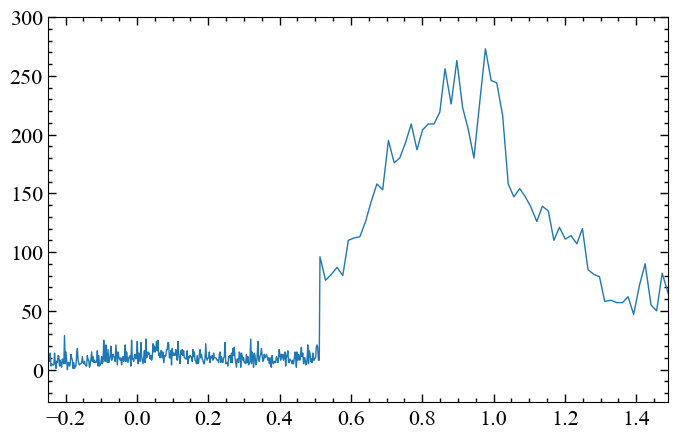

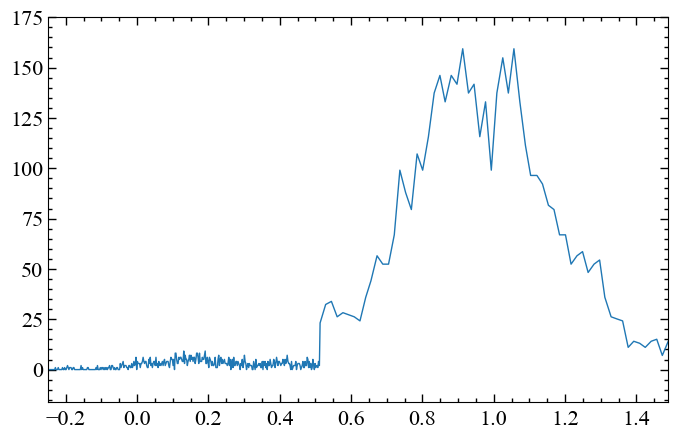

In [62]:
asim_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=asimCounts, skip_checks=True,dt=binsize)
asim_lc.plot()
kw_lc.plot()

Total lagg (s):  0.476 | CC lagg:  0.006   tlagg_approx:  0.47


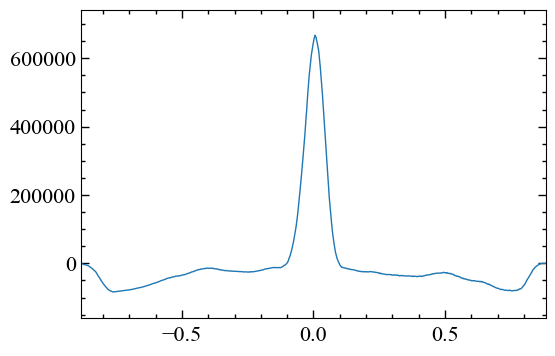

<AxesSubplot: >

In [63]:
CC = CrossCorrelation(kw_lc,asim_lc,mode="full")
CClagg=CC.time_shift
tlagg = tlagg_approx + CClagg
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg, '  tlagg_approx: ', tlagg_approx)
CC.plot()

In [64]:
tlagg = 0.476
df_burst['tus'] = df_burst['tus'].to_numpy() + tlagg*1e6

tus array OK ...


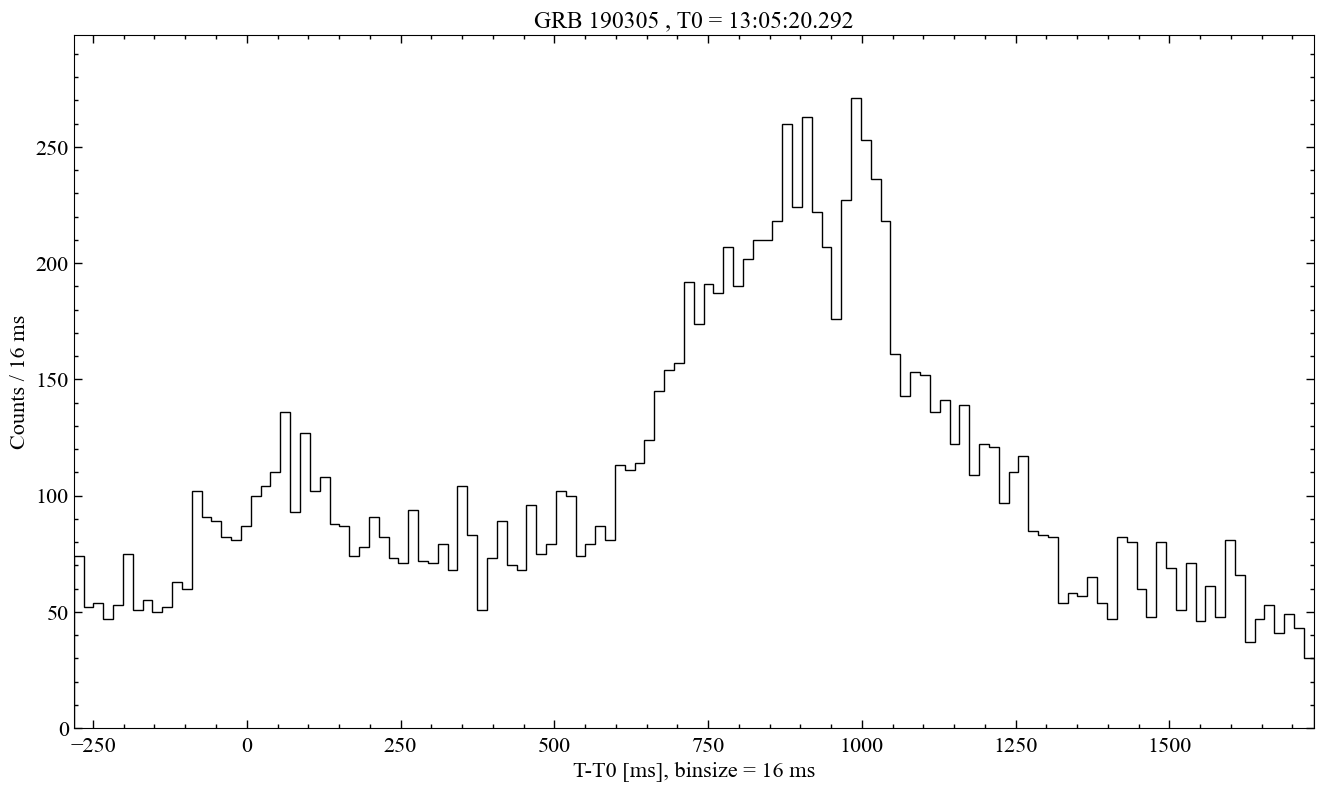

In [65]:
plot_HED(tus_arr=df_burst['tus'].to_numpy(),binsize=16,T0=T0+timedelta(seconds=tlagg))

In [66]:
df_burst.head()

,year,month,day,hour,minute,second,energy_ch,dau,det,datetime,tus,adr,keV,st,dt,flag
8440,2019,3,5,13,5,19.058593,1768,1,1,2019-03-05 13:05:19.058593278,-281406.722,1,29799.646444,25.000000,0.000,False
8453,2019,3,5,13,5,19.060647,66,1,1,2019-03-05 13:05:19.060646778,-279353.222,1,600.127636,1.400511,2053.500,False
8463,2019,3,5,13,5,19.061622,1925,1,1,2019-03-05 13:05:19.061621972,-278378.028,1,33968.798400,26.587519,975.194,False
8472,2019,3,5,13,5,19.062818,26,1,1,2019-03-05 13:05:19.062817583,-277182.417,1,266.189556,0.000000,1195.611,False
8483,2019,3,5,13,5,19.067037,72,1,1,2019-03-05 13:05:19.067037111,-272962.889,1,651.613804,1.606455,4219.528,False


# SPECTRUM

### BACKGROUND

In [67]:
df_keV_bg = keV_hist(df_bg,time_interval='max',keV_interval='max')

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  8416
n triggers are within bounds  8416
keV bins are set for HED
Energies binned!


In [68]:
df_keV_bg.tail()

,bins_keV,counts,poisson_error_counts
36,39810.72,521,22.825424
37,50118.72,12,3.464102
38,63095.73,0,0.000000
39,79432.82,0,0.000000
40,100000.00,0,0.000000


### BURST

In [69]:
df_keV_burst = keV_hist(df_burst,time_interval=(0.768,1.280),keV_interval='max',convert_seconds=True)

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  5753
n triggers are within bounds  5753
keV bins are set for HED
Energies binned!


In [72]:
df_keV_burst.head(40)

,bins_keV,counts,poisson_error_counts
0,10.00000,0,0.000000
1,12.58925,0,0.000000
2,15.84893,0,0.000000
3,19.95262,0,0.000000
4,25.11886,0,0.000000
5,31.62278,0,0.000000
6,39.81072,0,0.000000
7,50.11872,0,0.000000
8,63.09573,0,0.000000
9,79.43282,0,0.000000


# FITS

In [73]:
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

## BAK

In [74]:
print(T0+timedelta(seconds=tlagg))
print(min(df_bg['tus'].to_numpy()/1e6),max(df_bg['tus'].to_numpy())/1e6)

2019-03-05 13:05:20.292000
-92.293899444 -90.285259028


In [75]:
#EXPOSURE
print(min(df_bg['tus'].to_numpy()/1e6)-max(df_bg['tus'].to_numpy())/1e6)

-2.0086404160000058


In [76]:
ra,dec=340.399,-10.588

In [77]:
BAK_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-03-05T13:05:20.292','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [-92.294,'[s] Start time of background spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [-90.285,'End time of background spectrum accumulation'], #<float> [s]
    'EXPOSURE': [2.00864,'[s] Integration time in seconds for the BAK data'], #<float> 
    'OBJECT': ['GRB190305A','Name of the observed object'], #<str> 
    'RA_OBJ': [340.399,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-10.588,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB190305A.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}


In [81]:
generateBAK(BAK_dict=BAK_dict,
            bakCounts=df_keV_bg['counts'][1:].to_numpy(dtype=np.int32),
            stat_err=df_keV_bg['poisson_error_counts'][1:].to_numpy(dtype=np.float32),
            bin_lo=df_keV_bg['bins_keV'][:-1].to_numpy(dtype=np.float32),
            bin_hi=df_keV_bg['bins_keV'][1:].to_numpy(dtype=np.float32)
           )

## PHA

In [82]:
PHA_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-03-05T13:05:20.292','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.768,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [1.280,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.512,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB190305A','Name of the observed object'], #<str> 
    'RA_OBJ': [340.399,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-10.588,'[deg] Dec of source'], #<float>
    'BACKFILE': ['HED_GRB190305A.bak','Background FITS file'], #<str> ('example.bak')
    'RESPFILE': ['HED_GRB190305A.rsp','Response FITS file'], #<str> ('example.rsp')
    'FILENAME': ['HED_GRB190305A.pha','PHA filename'] #<str>  ('example.pha')
}


In [83]:
generatePHA(PHA_dict=PHA_dict,
            counts=df_keV_burst['counts'][1:].to_numpy(dtype=np.int16),
            stat_err=df_keV_burst['poisson_error_counts'][1:].to_numpy(dtype=np.float32),
            bin_lo=df_keV_burst['bins_keV'][:-1].to_numpy(dtype=np.float32),
            bin_hi=df_keV_burst['bins_keV'][1:].to_numpy(dtype=np.float32))

### RSP
    Used from theta,phi angles

In [84]:
theta,phi=133.904,-2.076

In [85]:
find_DRM_file(dir_path='/Users/andreas/phys/master/HED_DRM/',
             theta=theta,phi=phi)

'HED_drm_mats_135.00_0.00.txt'

In [86]:
RSP_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-03-05T13:05:20.292','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.768,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [1.280,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.512,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB190305A','Name of the observed object'], #<str> 
    'RA_OBJ': [340.399,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-10.588,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB190305A.rsp','RSP filename'] #<str>  ('example.pha')
}

In [87]:
generateRSP(RSP_dict=RSP_dict, 
            DRM_fname='HED_drm_mats_135.00_0.00.txt', 
            bin_lo=df_keV_burst['bins_keV'][:-1].to_numpy(dtype=np.float32),
            bin_hi=df_keV_burst['bins_keV'][1:].to_numpy(dtype=np.float32),
            theta=theta,
            phi=phi,
            see_headers=False)